In [ ]:
#default_exp vision.byol

# BYOL

> **BYOL**: [Bootstrap Your Own Latent A New Approach to Self-Supervised Learning](https://arxiv.org/pdf/2006.07733.pdf)

In [ ]:
#export
from fastai.vision.all import *
from self_supervised.augmentations import *
from self_supervised.layers import *

## Algorithm

#### BYOL

![BYOL](images/byol.png)

**Abstract**: We introduce Bootstrap Your Own Latent (BYOL), a new approach to self-supervised image
representation learning. BYOL relies on two neural networks, referred to as online and target
networks, that interact and learn from each other. From an augmented view of an image, we train
the online network to predict the target network representation of the same image under a different
augmented view. At the same time, we update the target network with a slow-moving average
of the online network. While state-of-the art methods rely on negative pairs, BYOL achieves a
new state of the art without them. BYOL reaches 74:3% top-1 classification accuracy on ImageNet
using a linear evaluation with a ResNet-50 architecture and 79:6% with a larger ResNet. We
show that BYOL performs on par or better than the current state of the art on both transfer and
semi-supervised benchmarks. Our implementation and pretrained models are given on GitHub.3

In [ ]:
#export
class BYOLModel(Module):
    "Compute predictions of v1 and v2" 
    def __init__(self,encoder,projector,predictor):
        self.encoder,self.projector,self.predictor = encoder,projector,predictor    

    def forward(self,v1,v2):
        "Symmetric predictions for symmetric loss calc"
        q1 = self.predictor(self.projector(self.encoder(v1)))
        q2 = self.predictor(self.projector(self.encoder(v2)))
        return (q1,q2)

You can either use `BYOLModel` module to create a model by passing predefined `encoder`, `projector` and `predictor` models or you can use `create_byol_model` with just passing predefined encoder and expected input channels.

You may notice `projector`/mlp module defined here is different than the one defined in SimCLR, in the sense that it has a batchnorm layer. You can read this great [blog post](https://untitled-ai.github.io/understanding-self-supervised-contrastive-learning.html) for a better intuition on the effect of the batchnorm layer in `BYOL`.

In [ ]:
#export
def create_byol_model(encoder, hidden_size=4096, projection_size=256):
    "Create BYOL model"
    n_in  = in_channels(encoder)
    with torch.no_grad(): representation = encoder(torch.randn((2,n_in,128,128)))
    projector = create_mlp_module(representation.size(1), hidden_size, projection_size, bn=True)
    predictor = create_mlp_module(projection_size, hidden_size, projection_size, bn=True)
    apply_init(projector)
    apply_init(predictor)
    return BYOLModel(encoder, projector, predictor)

In [ ]:
encoder = create_encoder("tf_efficientnet_b0_ns", n_in=3, pretrained=False, pool_type=PoolingType.CatAvgMax)
model = create_byol_model(encoder, hidden_size=2048, projection_size=128)
out = model(torch.randn((2,3,224,224)), torch.randn((2,3,224,224)))
out[0].shape, out[1].shape

(torch.Size([2, 128]), torch.Size([2, 128]))

## BYOL Callback

The following parameters can be passed;

- **m** is momentum for target encoder/model update, a similar idea to MoCo.
- **aug_pipelines** list of augmentation pipelines List[Pipeline] created using functions from `self_supervised.augmentations` module. Each `Pipeline` should be set to `split_idx=0`. You can simply use `get_byol_aug_pipelines` utility to get aug_pipelines.

BYOL algorithm uses 2 views of a given image, and `BYOL` callback expects a list of 2 augmentation pipelines in `aug_pipelines`.

You can simply use helper function `get_byol_aug_pipelines()` which will only except augmentation related arguments such as size, rotate, jitter...and will return a list of 2 pipelines, which we can be passed to the callback. This function uses `get_multi_aug_pipelines` which then `get_batch_augs`. For more information you may refer to `self_supervised.augmentations` module.

Also, you may choose to pass your own list of aug_pipelines which needs to be List[Pipeline, Pipeline] where Pipeline(..., split_idx=0). Here, `split_idx=0` forces augmentations to be applied in training mode.

In [ ]:
#export
@delegates(get_multi_aug_pipelines)
def get_byol_aug_pipelines(size, **kwargs): return get_multi_aug_pipelines(n=2, size=size, **kwargs)

In [ ]:
#export
from copy import deepcopy

class BYOL(Callback):
    order,run_valid = 9,True
    def __init__(self, m=0.999, aug_pipelines=[], print_augs=False):        
        assert_aug_pipelines(aug_pipelines)
        self.aug1, self.aug2 = aug_pipelines
        if print_augs: print(self.aug1), print(self.aug2)
        store_attr("m")

    def before_fit(self):
        "Create target model"
        self.target_model = deepcopy(self.learn.model).to(self.dls.device)
        for param_k in self.target_model.parameters(): param_k.requires_grad = False 
        self.learn.loss_func = self.lf
        
    def before_batch(self):
        "Generate 2 views of the same image and calculate target projections for these views"
        v1,v2 = self.aug1(self.x), self.aug2(self.x.clone())
        self.learn.xb = (v1,v2)
    
        with torch.no_grad():
            z1 = self.target_model.projector(self.target_model.encoder(v1))
            z2 = self.target_model.projector(self.target_model.encoder(v2))
            self.learn.yb = (z1,z2)

            
    def _mse_loss(self, x, y):
        x,y = F.normalize(x), F.normalize(y)
        return 2 - 2 * (x * y).sum(dim=-1)

    
    def lf(self, pred, *yb):
        (q1,q2),(z1,z2) = pred,yb
        return (self._mse_loss(q1,z2) + self._mse_loss(q2,z1)).mean()
        
 
    @torch.no_grad()
    def _momentum_update_target_encoder(self):
        for param_q, param_k in zip(self.learn.model.parameters(), self.target_model.parameters()):
            param_k.data = param_k.data * self.m + param_q.data * (1. - self.m)
            

    def after_step(self):
        "Momentum update target model"
        self._momentum_update_target_encoder()

        
    @torch.no_grad()
    def show(self, n=1):
        x1,x2  = self.learn.xb
        bs = x1.size(0)
        idxs = np.random.choice(range(bs),n,False)
        x1 = self.aug1.decode(x1[idxs].to('cpu').clone()).clamp(0,1)
        x2 = self.aug2.decode(x2[idxs].to('cpu').clone()).clamp(0,1)
        images = []
        for i in range(n): images += [x1[i],x2[i]] 
        return show_batch(x1[0], None, images, max_n=n * n, ncols=None, nrows=n)

### Example Usage

In [ ]:
path = untar_data(URLs.MNIST_TINY)
items = get_image_files(path)
tds = Datasets(items, [PILImageBW.create, [parent_label, Categorize()]], splits=GrandparentSplitter()(items))
dls = tds.dataloaders(bs=5, after_item=[ToTensor(), IntToFloatTensor()], device='cpu')

In [ ]:
fastai_encoder = create_encoder('xresnet18', n_in=1, pretrained=False)
model = create_byol_model(fastai_encoder, hidden_size=4096, projection_size=256)
aug_pipelines = get_byol_aug_pipelines(size=28, rotate=False, jitter=False, bw=False, blur=False, stats=None, cuda=False)
learn = Learner(dls, model, cbs=[BYOL(aug_pipelines=aug_pipelines, print_augs=True), ShortEpochCallback(0.001)])

Pipeline: RandomResizedCrop -> RandomHorizontalFlip
Pipeline: RandomResizedCrop -> RandomHorizontalFlip


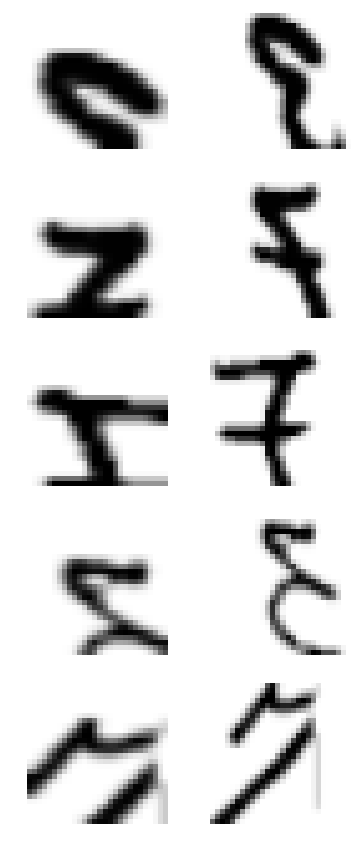

In [ ]:
b = dls.one_batch()
learn._split(b)
learn('before_fit')
learn('before_batch')
axes = learn.byol.show(n=5)

In [ ]:
learn.fit(1)

In [ ]:
learn.recorder.losses

[tensor(4.1046)]

## Export -

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 01 - augmentations.ipynb.
Converted 02 - layers.ipynb.
Converted 03 - distributed.ipynb.
Converted 10 - simclr.ipynb.
Converted 11 - moco.ipynb.
Converted 12 - byol.ipynb.
Converted 13 - swav.ipynb.
Converted 20 - clip.ipynb.
Converted 21 - clip-moco.ipynb.
Converted index.ipynb.
